In [146]:
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy as sc
import gc
import joblib

pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 500)

In [147]:
def show_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

In [148]:
# Read csv
#file1 = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\csv\complete_dataset_labeled_wLastPurchaseDates_wWeek0.csv'
file2 = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\csv\complete_dataset_labeled_wLastPurchaseDates_wWeek0_date.csv'
df_data = pd.read_csv(file2, sep='|', dtype={'userID':np.uint32,
                                            #'purchaseDates':str,
                                            'date':str, 
                                            'itemID':np.uint32,
                                            'order':np.uint8,
                                            'brand':np.uint16,
                                            'feature_1':np.uint8,
                                            'feature_2':np.uint8,
                                            'feature_3':np.uint16,
                                            'feature_4':np.uint8,
                                            'feature_5':np.uint16,
                                            'week':np.uint8})
                     #chunksize=10000)

#df_data2 = pd.read_csv(r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\csv\complete_dataset_labeled_wLastPurchaseDates.csv', sep='|', chunksize=50000)

show_mem_usage(df_data)
df_data.head()
#df_data.get_chunk()

Memory usage of dataframe is 35.70 MB


,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",0
1,2020-06-01,10318,4735,1,791,10,1,504,0,17,"[2459, 2197, 61, 3604, 1861, 3916]",0
2,2020-06-01,10318,20343,1,194,10,0,506,3,65535,"[826, 3755, 2041, 1546, 199, 2995, 871, 3702, ...",0
3,2020-06-01,10318,20672,1,963,10,0,507,3,123,"[806, 2091, 2073, 2304, 3976]",0
4,2020-06-01,10318,2918,1,441,10,0,507,0,39,"[2091, 2023]",0


# Preprocessing

In [149]:
# Drop columns (only for file1)
#df_data.drop('lastPurchaseDate', axis=1, inplace=True)
#df_data.drop('Unique count(date)', axis=1, inplace=True)

df_data = df_data.sort_values('date')

df_data.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",0
3394,2020-06-01,11575,3997,1,194,10,0,505,0,126,"[2060, 955, 2636, 3013, 293, 1578, 3446, 3915,...",0
3393,2020-06-01,27306,27936,1,618,4,0,323,0,144,"[30, 1763, 3915, 1060, 1525, 3914, 3444, 871]",0
3392,2020-06-01,2961,7021,1,1324,10,0,421,3,3,"[196, 3224, 2580, 2403, 2690, 3453, 3915, 3914]",1
3391,2020-06-01,16239,8526,1,322,6,0,536,0,46,[981],0


### Multi-Hot-Encoding for categories

In [150]:
df_data_chunk = df_data.iloc[:50000,:] # set chunk size for tests
#df_data_chunk = df_data

df_data_chunk.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",0
3394,2020-06-01,11575,3997,1,194,10,0,505,0,126,"[2060, 955, 2636, 3013, 293, 1578, 3446, 3915,...",0
3393,2020-06-01,27306,27936,1,618,4,0,323,0,144,"[30, 1763, 3915, 1060, 1525, 3914, 3444, 871]",0
3392,2020-06-01,2961,7021,1,1324,10,0,421,3,3,"[196, 3224, 2580, 2403, 2690, 3453, 3915, 3914]",1
3391,2020-06-01,16239,8526,1,322,6,0,536,0,46,[981],0


In [151]:
df_data_chunk['date'] = pd.to_datetime(df_data_chunk['date'], format="%Y-%m-%d")
df_data_chunk['day'] = df_data_chunk['date'].dt.day

df_data_chunk['label'] = (df_data_chunk['day'].astype(str)+"|"+df_data_chunk['week'].astype(str)).astype(str)
df_data_chunk.drop('day', axis=1, inplace=True)
df_data_chunk.drop('week', axis=1, inplace=True)

df_data_chunk.head()

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,label
0,2020-06-01,38769,3477,1,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",1|0
3394,2020-06-01,11575,3997,1,194,10,0,505,0,126,"[2060, 955, 2636, 3013, 293, 1578, 3446, 3915,...",1|0
3393,2020-06-01,27306,27936,1,618,4,0,323,0,144,"[30, 1763, 3915, 1060, 1525, 3914, 3444, 871]",1|0
3392,2020-06-01,2961,7021,1,1324,10,0,421,3,3,"[196, 3224, 2580, 2403, 2690, 3453, 3915, 3914]",1|1
3391,2020-06-01,16239,8526,1,322,6,0,536,0,46,[981],1|0


In [152]:
# convert string to list of integers in 'categories'
df_data_chunk["categories"] = df_data_chunk["categories"].apply(lambda x: [int(i) for i in x[1:-1].split(',')])
df_data_chunk["categories"]

0                              [74, 4109, 3867, 803, 4053]
3394     [2060, 955, 2636, 3013, 293, 1578, 3446, 3915,...
3393         [30, 1763, 3915, 1060, 1525, 3914, 3444, 871]
3392       [196, 3224, 2580, 2403, 2690, 3453, 3915, 3914]
3391                                                 [981]
3390                               [2790, 871, 2417, 2454]
3389                                          [1920, 2658]
3388     [3766, 2389, 3693, 1174, 3173, 3625, 2872, 391...
3387                                           [2833, 498]
3386                                          [2799, 3244]
3385                          [2624, 3259, 88, 3349, 3653]
3384                         [3259, 987, 1064, 2624, 3653]
3383                        [2209, 3176, 3283, 2257, 3915]
3382                                 [47, 279, 1319, 3915]
3381     [664, 669, 1760, 1763, 3924, 3915, 3912, 3914,...
3380     [1515, 2330, 1760, 3245, 2443, 3173, 3915, 391...
3395                                     [3200, 480, 404

In [153]:
from sklearn.preprocessing import MultiLabelBinarizer
c = df_data_chunk["categories"]
mlb = MultiLabelBinarizer(sparse_output=False) # Set to True if output binary array is desired in CSR sparse format

df_multi_hot = pd.DataFrame(mlb.fit_transform(c), columns=mlb.classes_, index=None, dtype=np.int8)
#df_multi_hot = pd.DataFrame(mlb.fit_transform(c))
show_mem_usage(df_multi_hot)

Memory usage of dataframe is 141.33 MB


In [154]:
sparse_df_mh = df_multi_hot.astype(pd.SparseDtype("float64",0))
print(sparse_df_mh.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 2964 entries, 0 to 4296
dtypes: Sparse[float64, 0](2964)
memory usage: 3.8 MB
None


,0,1,2,4,5,7,12,13,14,17,...,4278,4281,4284,4285,4286,4287,4288,4289,4290,4296
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
del df_multi_hot
gc.collect()

33

In [156]:
# Combine df_data and sparse_df_mh
df_combined = df_data_chunk.join(sparse_df_mh, how='inner')
show_mem_usage(df_combined)
#df_combined

Memory usage of dataframe is 5.87 MB


In [157]:
# pop and append 'week' at end of dataframe
#col = df_combined.pop("day")
#df_combined.insert(len(df_combined.columns), col.name, col)
#col = df_combined.pop("week")
#df_combined.insert(len(df_combined.columns), col.name, col)
#df_combined.head()
col = df_combined.pop("label")
df_combined.insert(len(df_combined.columns), col.name, col)
#df_combined.head()

In [158]:
# Check if we have any missing values
df_combined[df_combined.isnull().any(axis=1)]

,date,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,...,4281,4284,4285,4286,4287,4288,4289,4290,4296,label


### Datatypes for XGBoost

XGBoost natively supports continuous data but not categorical data. In order to use categorical data with XGBoost, we have to use One-Hot-Encoding which converts a column of categorical values into muliple columns of binary values.

# Modeling

In [159]:
df_combined.drop('categories', axis=1, inplace=True)
show_mem_usage(df_combined)

Memory usage of dataframe is 5.51 MB


In [120]:
# get index of first occurance of january date for split
idx = df_combined.date.searchsorted('2021-01-01', side='left') # list needs to be sorted already for searchsorted
idx

AttributeError: 'DataFrame' object has no attribute 'date'

In [45]:
# check index
df_combined['date'][idx], df_combined['date'][idx - 1]

(Timestamp('2020-06-13 00:00:00'), Timestamp('2020-06-13 00:00:00'))

In [160]:
# drop date
df_combined.drop('date', axis=1, inplace=True)

In [161]:
# Comma is being used to extract a specific column from a 2D array.
# X = data.iloc[:,:-1]
# X = all rows, all columns except the last one 

X = df_combined.iloc[:,0:-1]
X

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4278,4281,4284,4285,4286,4287,4288,4289,4290,4296
0,38769,3477,1,186,6,0,196,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3394,11575,3997,1,194,10,0,505,0,126,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3393,27306,27936,1,618,4,0,323,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3392,2961,7021,1,1324,10,0,421,3,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3391,16239,8526,1,322,6,0,536,0,46,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3390,8542,25689,1,1180,1,1,522,3,9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3389,8001,2826,1,1111,10,0,487,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3388,38018,31702,3,703,10,0,345,0,97,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3387,38018,20101,1,1090,10,1,502,0,185,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3386,38018,29741,1,1496,10,0,287,3,87,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
y = df_combined.iloc[:,-1]

#days = [day for day in range(1,32)]
#weeks = [week for week in range(0,5)]
#label_combi = [[day, week] for day in days for week in weeks]

y.head(50)

0       1|0
3394    1|0
3393    1|0
3392    1|1
3391    1|0
3390    1|0
3389    1|0
3388    1|1
3387    1|0
3386    1|0
3385    1|1
3384    1|1
3383    1|1
3382    1|1
3381    1|0
3380    1|1
3395    1|0
3396    1|0
3397    1|0
3398    1|0
3414    1|0
3413    1|0
3412    1|1
3411    1|0
3410    1|0
3409    1|0
3408    1|0
3379    1|0
3407    1|0
3405    1|0
3404    1|0
3403    1|1
3402    1|0
3401    1|0
3400    1|0
3399    1|0
3406    1|0
3378    1|1
3377    1|0
3376    1|0
3355    1|1
3354    1|0
3353    1|0
3352    1|1
3351    1|1
3350    1|0
3349    1|0
3356    1|1
3348    1|0
3346    1|0
Name: label, dtype: object

In [163]:
# Split training/test data
# train = jun-dec20 / test = jan21
idx=40000
X_train = X.iloc[:idx-1]
X_test = X.iloc[idx:]
y_train = y.iloc[:idx-1]
y_test = y.iloc[idx:]

In [164]:
show_mem_usage(X_train), show_mem_usage(X_test)
X_train

Memory usage of dataframe is 4.01 MB
Memory usage of dataframe is 0.77 MB


,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4278,4281,4284,4285,4286,4287,4288,4289,4290,4296
0,38769,3477,1,186,6,0,196,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3394,11575,3997,1,194,10,0,505,0,126,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3393,27306,27936,1,618,4,0,323,0,144,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3392,2961,7021,1,1324,10,0,421,3,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3391,16239,8526,1,322,6,0,536,0,46,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3390,8542,25689,1,1180,1,1,522,3,9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3389,8001,2826,1,1111,10,0,487,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3388,38018,31702,3,703,10,0,345,0,97,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3387,38018,20101,1,1090,10,1,502,0,185,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3386,38018,29741,1,1496,10,0,287,3,87,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
y_train

0         1|0
3394      1|0
3393      1|0
3392      1|1
3391      1|0
3390      1|0
3389      1|0
3388      1|1
3387      1|0
3386      1|0
3385      1|1
3384      1|1
3383      1|1
3382      1|1
3381      1|0
3380      1|1
3395      1|0
3396      1|0
3397      1|0
3398      1|0
3414      1|0
3413      1|0
3412      1|1
3411      1|0
3410      1|0
3409      1|0
3408      1|0
3379      1|0
3407      1|0
3405      1|0
3404      1|0
3403      1|1
3402      1|0
3401      1|0
3400      1|0
3399      1|0
3406      1|0
3378      1|1
3377      1|0
3376      1|0
3355      1|1
3354      1|0
3353      1|0
3352      1|1
3351      1|1
3350      1|0
3349      1|0
3356      1|1
3348      1|0
3346      1|0
3345      1|0
3344      1|0
3343      1|1
3342      1|0
3341      1|0
3340      1|0
3347      1|0
3415      1|1
3357      1|0
3359      1|0
3375      1|1
3374      1|1
3373      1|0
3372      1|0
3371      1|0
3370      1|0
3369      1|0
3358      1|1
3368      1|0
3366      1|1
3365      1|0
3364  

In [21]:
# Split training and test data
# parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

#show_mem_usage(X_train), show_mem_usage(X_test)

### Train Model (or load)

In [166]:
# train (if not loading, see below)
model1 = XGBClassifier()
xgm = model1.fit(X_train, y_train)

# use this for loading model:
#filepath = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\models\gbm_jun-dec-train_completeLabeled_wWeek0.sav'
#xgm = joblib.load(filepath)

# predict
y_train_pred = xgm.predict(X_train)
y_test_pred = xgm.predict(X_test)

# get accuracies
xgm_train = accuracy_score(y_train, y_train_pred)
xgm_test = accuracy_score(y_test, y_test_pred)
print()
print(f'XGboost train/test accuracies '
     f'{xgm_train:.3f}/{xgm_test:.3f}')

[22:34:42] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

XGboost train/test accuracies 0.402/0.000


In [145]:
y_test_pred

array([6., 6., 6., ..., 6., 3., 6.])

<AxesSubplot:>

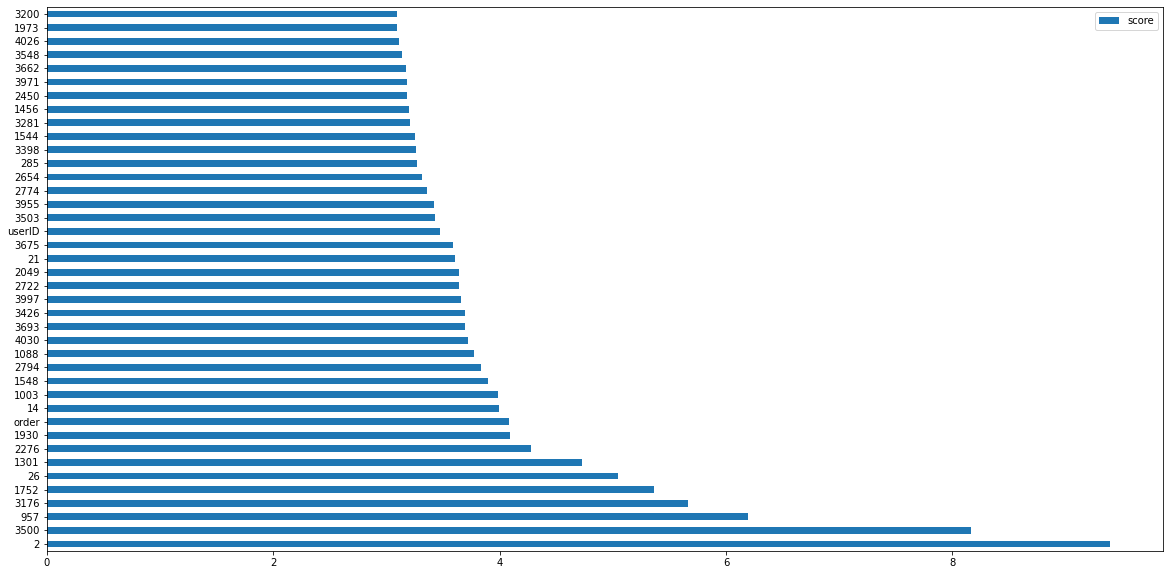

In [141]:
# ‘gain’: the average gain across all splits the feature is used in.
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
feature_important = xgm.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

#### Save Model

In [27]:
# save model ('gbm', see above) with joblib

#filepath = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\models\gbm_jun-dec-train_completeLabeled_wWeek0.sav'
#joblib.dump(gbm, filepath)

### Predict

In [142]:
# create dataframe from test-prediction with index from X_test
df_y_test_pred = pd.DataFrame(y_test_pred, columns=['week_pred'], index=X_test.index, dtype=np.int8)

# concatenate X_test, y_test, y_pred (put columns next to each other)
df_eval_test = pd.concat([X_test, y_test, df_y_test_pred], axis=1)

In [144]:
# show rows of correctly predicted weeks where week != 0 
df_eval_test.head(150)

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4284,4285,4286,4287,4288,4289,4290,4296,label,week_pred
41602,12051,28812,2,829,4,0,351,0,78,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,6
41591,45072,16906,1,120,10,0,503,3,186,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.2,6
41582,4803,12872,1,18,4,0,277,0,44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,6
41589,14560,22587,3,135,10,0,358,3,24,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.2,10
41574,7235,28297,2,504,10,1,445,0,59,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,6
41575,23058,6445,1,598,4,1,491,0,66,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.2,7
41604,40041,5548,1,378,10,0,412,0,84,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,6
41576,23058,30445,1,829,10,0,515,0,131,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.2,5
41577,23058,29042,1,135,4,0,487,3,175,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2
41578,23058,3708,1,135,4,0,484,3,175,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2


In [30]:
# show 150 rows of predicted weeks where prediction was wrong
df_eval_test.loc[(df_eval_test['week'] != df_eval_test['week_pred']) & (df_eval_test['week'] != 0)].head(250)

,userID,itemID,order,brand,feature_1,feature_2,feature_3,feature_4,feature_5,0,...,4289,4290,4292,4293,4294,4296,4298,4299,week,week_pred
905945,45525,461,1,406,10,0,503,0,17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905930,36249,387,1,325,10,0,16,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905931,27130,23534,1,1180,4,0,398,0,129,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905932,27130,24303,1,797,10,0,491,0,156,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905946,9629,3113,1,290,10,0,345,3,99,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905933,30838,6809,1,827,4,0,55,3,49,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905934,195,23348,1,1371,10,0,344,0,99,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905935,10336,20478,1,539,6,0,303,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905938,28089,21704,1,186,4,0,15,0,81,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
905937,45737,6112,1,1065,4,0,324,0,44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


# DecisionTreeClassifier

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier

# train
classifier = DecisionTreeClassifier()
dcm = classifier.fit(X_train,y_train)

# use this for loading model:
#filepath = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\models\dcm_jun-dec-train_completeLabeled_wWeek0.sav'
#gbm = joblib.load(filepath)

# predict
y_train_pred2 = dcm.predict(X_train)
y_test_pred2 = dcm.predict(X_test)

# get accuracies
dcm_train = accuracy_score(y_train, y_train_pred2)
dcm_test = accuracy_score(y_test, y_test_pred2)
print()
print(f'DecTree train/test accuracies '
     f'{dcm_train:.3f}/{dcm_test:.3f}')

In [ ]:
# save model ('dcm', see above) with joblib

filepath = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\models\dcm_jun-dec-train_completeLabeled_wWeek0.sav'
joblib.dump(dcm, filepath)